# Solving ODEs

[File as PDF](https://github.com/fcichos/CBPM24/blob/cb4cdd123685863a57ead46c8cc25bc9de8f41a0/source/notebooks/L5/3_solving_ODEs.pdf)

All the stuff we have defined in the previous sections is useful for solving ordinary differential equations. This will bring us closer to solving out physics problems now. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.sparse import diags
from scipy.integrate import odeint

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

plt.rcParams.update({'font.size': 10,
                     'lines.linewidth': 1,
                     'lines.markersize': 5,
                     'axes.labelsize': 10,
                     'xtick.labelsize' : 9,
                     'ytick.labelsize' : 9,
                     'legend.fontsize' : 8,
                     'contour.linewidth' : 1,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.right' : True,
                     'ytick.direction' : 'in',
                     'figure.figsize': (4, 3),
                     'figure.dpi': 150 }) 

## Harmonic Oscillator 

<div class="alert alert-info">

**Physics Interlude:** The harmonic oscillator
    
We are going to tackle as a first very simple problem, the harmonic oscillator and we will demonstrate that with the matrix (Crank-Nicholson method or implicit scheme), the Euler type integration method and using some 'unknown' integrator in the module `SciPy`.
    
The equation of motion for a classical harmonic oscillator is given 

\begin{equation}
\frac{\mathrm{d}^2x}{\mathrm{d}t^2}+\omega^2 x=0
\end{equation}

This is a second order differential equation which requires for its solution two initial conditions. The first initial condition is the initial elongation $x(t=0)=x_{0}$ and the second the initial velocity $\dot{x}(t=0)=v_{0}$. 

</div>

## Implicit Solution - Crank Nicholson

Lets start with the matrix appraoch we have just learned about. Using the matrix version, we can transform the above equation into a system of coupled equations, which we can solve with some standard methods available from e.g. the `SciPy` module.

### Define Matrices



Our matrix will consist of two parts. The first containing the second derivative and the second just the elongation. Suppose we want to calculate the position $x(t)$ at 6 instances in time $t_{i}$ 
then the matrix version of the second derivative reads as

($x_{1}=x(t_{1}), \ldots$).

$T=\frac{d^2x}{dt^2}=\frac{1}{\delta t^2}
\begin{bmatrix}
-2 & 1  & 0 & 0 & 0 & 0\\
 1 & -2 & 1 & 0 & 0 & 0\\
 0 & 1  & -2 & 1 & 0 & 0\\
 0 & 0  & 1  & -2 & 1 & 0\\
 0 & 0  & 0  &  1 & -2 & 1\\
 0 & 0  & 0  &  0 &  1 & -2\\
\end{bmatrix}
\begin{bmatrix}
x_{1}\\
x_{2}\\
x_{3}\\
x_{4}\\
x_{5}\\
x_{6}
\end{bmatrix}$

The second term in the equation of motion is a multiplication of the elongation $x(t_{i})$ by $\omega^{2}$ and can be written as


$V=\omega^2 x=\begin{bmatrix}
\omega^2  & 0  & 0 & 0 & 0 & 0\\
 0 & \omega^2  & 0 & 0 & 0 & 0\\
 0 & 0  & \omega^2  & 0 & 0 & 0\\
 0 & 0  & 0  & \omega^2  & 0 & 0\\
 0 & 0  & 0  &  0 & \omega^2  & 0\\
 0 & 0  & 0  &  0 &  0 & \omega^2 \\
\end{bmatrix}
\begin{bmatrix}
x_{1}\\
x_{2}\\
x_{3}\\
x_{4}\\
x_{5}\\
x_{6}
\end{bmatrix}$

The left hand side of the would threfore contain a sum of the two matrices $M=T+V$ multiplied by the vector $x$.
We have therfore almost all things together to solve this differential equation with the help of an implicit scheme. What we have ignored so far are the initial conditions. 



### Use Initial Conditions


The matrix given for the second detivative actually implies already some initial (bounary) conditions. You probably noticed that the matrix contains incomplete coefficients for the second derivative in the first and last line. The first line contains $(-2,1)$, but the second derivative should contain $(1,-2,1)$. This $(-2,1)$ thus always includes the boundary condition that $x_{0}=0$. To include our own initial/boundary conditions, we have to construct the matrix for the second derivative slightly differently and modify the differential equation to 

\begin{equation}
\frac{\mathrm{d}^2x}{\mathrm{d}t^2}+\omega^2 x=b
\end{equation}

where the vector b takes care of the initial conditions.

If we have $N$ positions in time at which we calculate the elongation $x$, we have a $N\times N$ matrix of for the second derivatives. The lower $N-2$ lines will contain the the coefficients for the second derivative $(1,-2,1)$. The first two lines supply the initial/boundary conditions.

The initial condition for the elongation $x(t=0)=x_{0}$ is obtained when the first element of the first line is a **1**.
The matrix multiplication $M\, x=b$ for yields thus in the first line $x_{1}=b_{1}$ and we set $b_{1}=x_{0}$. The second line shall give the initial velocity. So the matrix entries of the second line contain a first derivative $(-1,1)$. The matrix multiplication thus yields $x_{2}-x_{1}=b_{2}$. We can therefore need to set $b_{2}=v_{0}\delta t$. All of the other entries of $b$ shall be set to zero according to the differential equation of the harmonic oscillator.

Our final problem $M\, x=b$ will thus have the following shape

\begin{equation}
\begin{bmatrix}
1 & 0  & 0 & 0 & 0 & 0\\
-1 & 1 & 0 & 0 & 0 & 0\\
1 & -2+\omega^2*\delta t^2  & 1 & 0 & 0 & 0\\
0 & 1  & -2+\omega^2*\delta t^2  & 1 & 0 & 0\\
0 & 0  & 1  &  -2+\omega^2*\delta t^2 & 1 & 0\\
0 & 0  & 0  &  1 &  -2+\omega^2*\delta t^2 & 1\\
\end{bmatrix}
\begin{bmatrix}
x_{1}\\
x_{2}\\
x_{3}\\
x_{4}\\
x_{5}\\
x_{6}
\end{bmatrix}=
\begin{bmatrix}
x_{0}\\
v_{0}\delta t\\
0\\
0\\
0\\
0
\end{bmatrix}
\end{equation}


### Solution

This is the final system of coupled equations which we can supply to any matrix solver. We will use a solver from the `scipy.linalg` module. Lets have a look at the details below.



In [4]:
N=5

In [5]:
(diags([-2., 1., 1.], [-1,-2, 0], shape=(N, N))+diags([1], [-1], shape=(N, N))* omega**2*dt**2)

<5x5 sparse matrix of type '<class 'numpy.float64'>'
	with 12 stored elements (3 diagonals) in DIAgonal format>

In [6]:
import numpy as np
from scipy.sparse import diags
import matplotlib.pyplot as plt

k = 15.5 # spring constant
m = 0.2 # mass
omega=np.sqrt(k/m) # frequency of the oscillator

L = np.pi # time period over which we solve the ODE
N = 500 # number of data points
t = np.linspace(0, L, N) # time axis

b = np.zeros(N) # initial conditions vector
b[0]=0 # initial elongation
b[1]=1 # initial velocity

x = np.zeros(N) # solution vector
dt = t[1] - t[0] # time intervall of each step

# construct the matrix
M = (diags([-2., 1., 1.], [-1,-2, 0], shape=(N, N))+diags([1], [-1], shape=(N, N))* omega**2*dt**2).todense()
M[0,0]=1 # initial condition for amplitude, x1=1
M[1,0]=-1 # initial condition for velocity, dx/dt=0
M[1,1]=1

# initial condition vector
b=b.transpose()

x= np.linalg.solve(M, b) # this is the solution


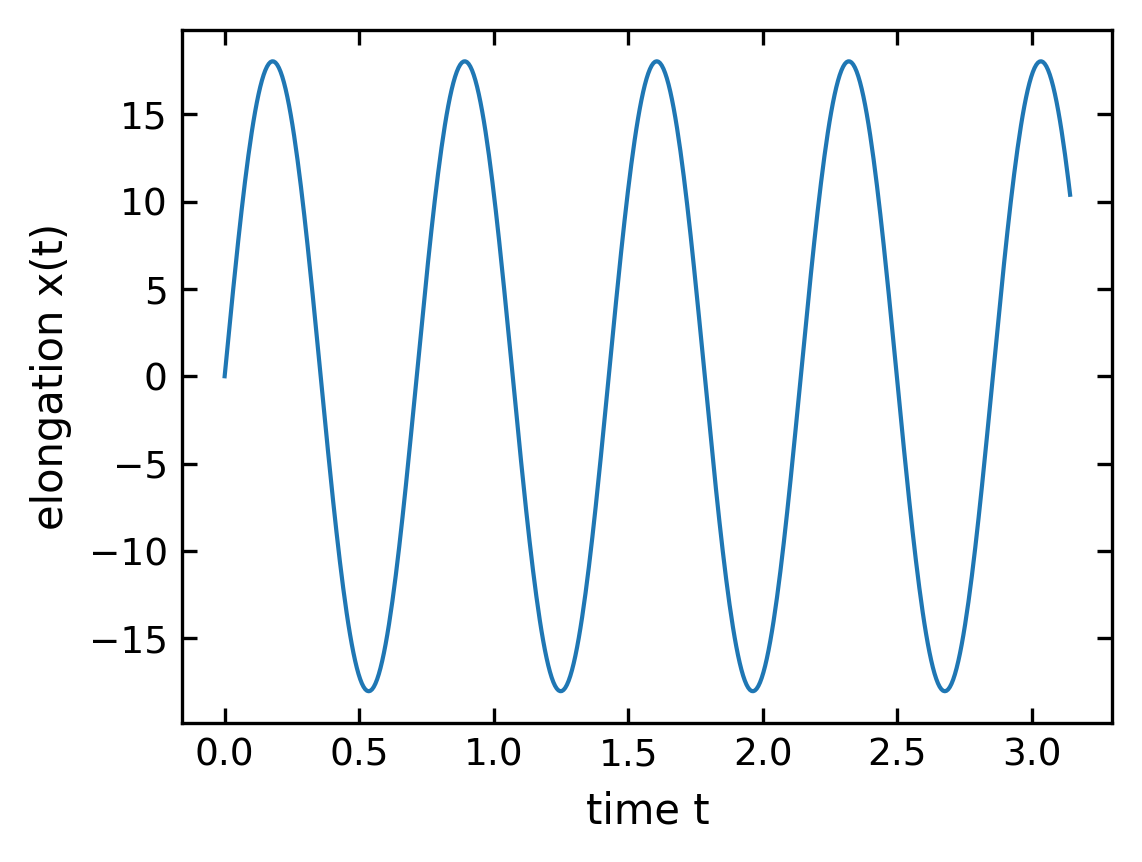

In [8]:
plt.figure(figsize=(4,3))
plt.plot(t,x)
plt.xlabel('time t')
plt.ylabel('elongation x(t)')
plt.show()

## Explicit Solution - Numerical Integration

Before we really dive into the explicit scheme, we take some time to develop a “standard model” for solving ODE’s. That way, we can set any problem up once and then use the method of our choice to solve it, with a minimum amount of reprogramming on our part.
Let's have a look at the free fall problem:

\begin{equation}
\ddot{x}= -g
\end{equation}

The above equartion can be broken into two first-order equations:

\begin{eqnarray}
\dot{x} &= v \label{test1}\\
\dot{v} &= - g \label{test2}
\end{eqnarray}



The individual Euler-method solutions to those first-order equations are 

\begin{eqnarray}
x_{i+1} &= x_i + \dot{x} \Delta t \label{eq:step1}\\
v_{i+1} &= v_i + \dot{v}\Delta t \label{eq:step2}
\end{eqnarray}




There is a symmetry in these two equations that just makes you want to write them as a single vector equation:

\begin{equation}
y_{i+1} = y_{i} + \dot{y} \Delta t
\end{equation}

where

\begin{equation}\label{eq:def1}
y=
\begin{bmatrix}
x \\
v 
\end{bmatrix}
\end{equation}


Therefore the two first order equation could be written with the same vector notation:

\begin{equation}\label{eq:def2}
\dot{y}=
\begin{bmatrix}
\dot{x} \\
-g 
\end{bmatrix}
\end{equation}

This defines the differential equation we’re solving.



This vector notation allows us to break the process into two parts: 

- defining the problem and 
- solving the problem. 

We define the problem with a function that returns the derivatives of each element in $y$. 
The solution has to be done by defining a function that is integrating the equation of motion according to one of the many possible integration methods. To keep it simple, we will introduce the **Euler**, the **Euler Cromer** and the **Midpoint** method. All of them are numerical integration methods and help us to solve first order differential equations.

There are much more accurate methods beyond the ones listed below, for example the **Runge Kutta Methods**. We leave that to you to study these methods and to possibly implement them.



### Euler Method
The **Euler method** follows naturally from a Taylor expansion of the function $x(t)$ around the current position $t$.

\begin{equation}
x(t+\Delta t)=x(t)+\dot{x}(t)\Delta t+\ddot{x}(t)\frac{\Delta t^{2}}{2}+ \ldots
\end{equation}

Dropping term of higher order than linear in $\Delta t$ yields

\begin{equation}
x(t+\Delta t) = x(t) + \dot{x}(t) \Delta t
\end{equation}

The error in each step for Euler’s method is therefore on the order of $\Delta t^{2}$, since that’s the first term omitted in the Taylor expansion. However, the number of steps is $N = \tau/\Delta t$ so the total error by the end of the process is on the order of $\Delta t$. Decreasing the size of $\Delta t$ improves your result linearly.


Notice that Euler’s method only works on first-order differential equations. This is not a limitation, though, because higher-order differential equations can be expanded into systems of first-order differential equations.

### Euler Cromer Method


The **Euler Cromer** method just changes a slight detail by using *not* the velocity at the current time $t$ for the calculation of the update of the position at time $t$ but the newly calculated velocity $\dot{x}(t+\Delta t)$

\begin{equation}
x(t+\Delta t) = x(t) + \dot{x}(t+\Delta t) \Delta t
\end{equation}

Due to the use of the future velocity, the **Euler Cromer** method typically underestimates the position while the **Euler method** overestimates the position. The error of the **Euler Cromer** method is also on the order of $\Delta t^2$ and the error increases with $N$.

### Midpoint Method

Both estimates can now be used to obtain the **midpoint method**. 

\begin{equation}
x(t+\Delta t) = x(t) + \frac{\dot{x}(t+\Delta t)+\dot{x}(t)}{2} \Delta t
\end{equation}

The error of this method scales now with $\Delta t^3$. The quality of these three methods is displayed in by the code and the graph below.

![Derivative](derivative.png)

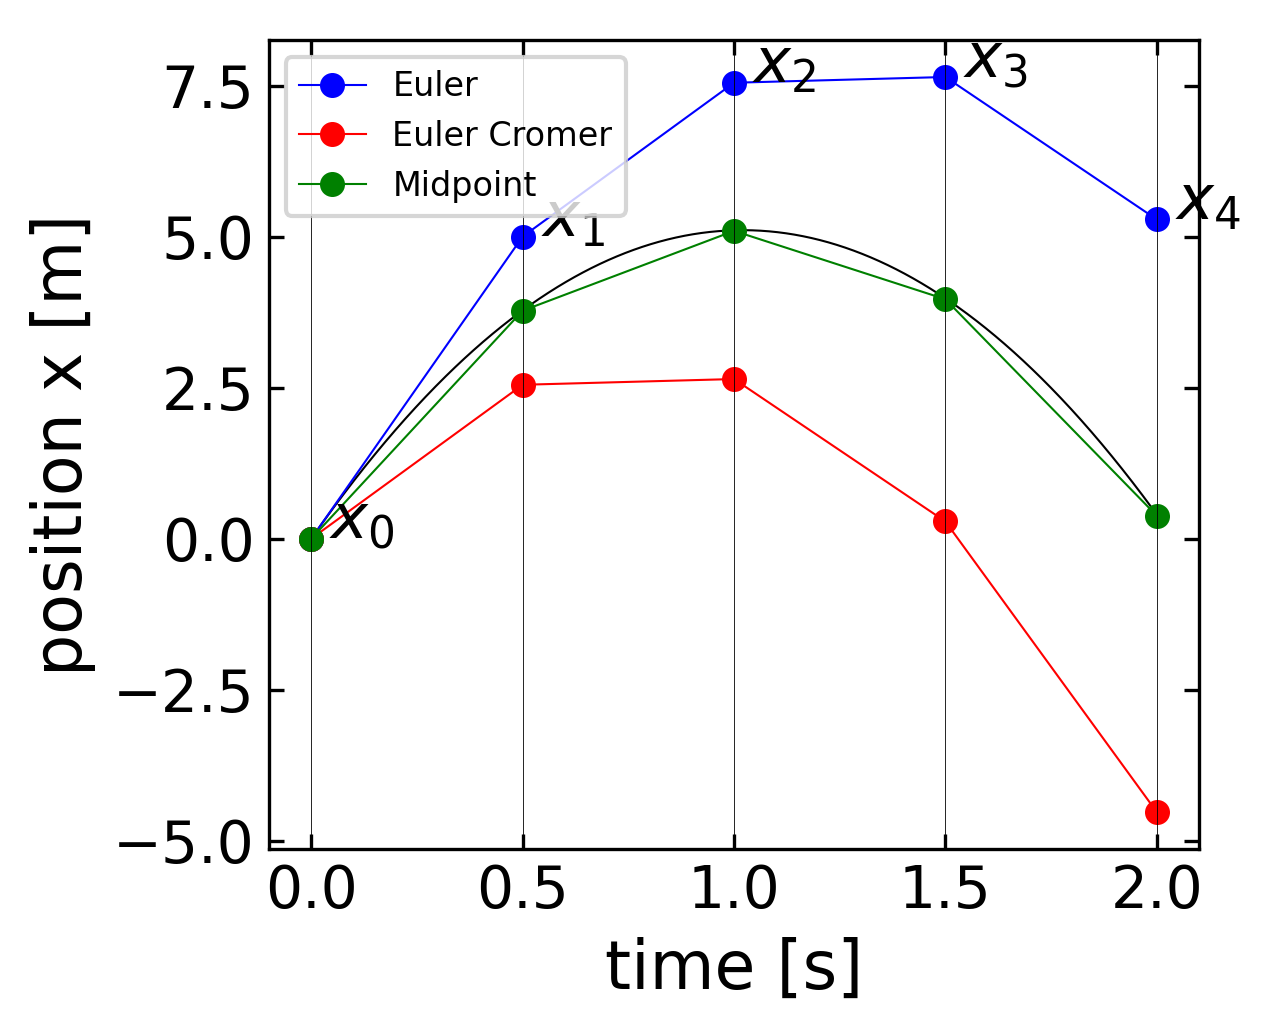

In [9]:
## high precision 
t=np.linspace(0,2,1000)
v=np.zeros(len(t))
x=np.zeros(len(t))

g=-9.81
v[0]=10
x[0]=0
dt=t[1]-t[0]

fig=plt.figure(1, figsize = (4,3.5) )

for i in range(0,len(t)-1):
    v[i+1]=v[i]+g*dt
    x[i+1]=x[i]+v[i]*dt

plt.plot(t,x,'k-',linewidth=0.5)



## Euler Method
t=np.linspace(0,2,5)
v=np.zeros(len(t))
x=np.zeros(len(t))

v[0]=10
x[0]=0
dt=t[1]-t[0]

for i in range(0,len(t)-1):
    v[i+1]=v[i]+g*dt
    x[i+1]=x[i]+v[i]*dt

plt.plot(t,x,'bo-',linewidth=0.5, label='Euler')
ax=fig.gca()
for i in range(0,len(t)):    
    ax.annotate(' $x_%s$' % i, xy=(t[i], x[i]), textcoords='data',fontsize=15)

## Euler Cromer Method
t=np.linspace(0,2,5)
v=np.zeros(len(t))
x=np.zeros(len(t))

v[0]=10
x[0]=0
dt=t[1]-t[0]

for i in range(0,len(t)-1):
    v[i+1]=v[i]+g*dt
    x[i+1]=x[i]+v[i+1]*dt

plt.plot(t,x,'ro-',linewidth=0.5,label='Euler Cromer')

## Average of Euler and Euler Cromer Method
t=np.linspace(0,2,5)
v=np.zeros(len(t))
x=np.zeros(len(t))

v[0]=10
x[0]=0
dt=t[1]-t[0]

for i in range(0,len(t)-1):
    v[i+1]=v[i]+g*dt
    x[i+1]=x[i]+(v[i+1]+v[i])*dt/2

plt.plot(t,x,'go-',linewidth=0.5,label='Midpoint')

for xc in t:
    plt.axvline(x=xc,color='black',linewidth=0.2)

plt.legend(loc='upper left')    
plt.xlabel('time [s]', fontsize=16)
plt.ylabel('position x [m]',fontsize=16)
plt.tick_params(labelsize=14)
plt.savefig('derivative.png')
plt.show()

### Putting it all together


We are now in the position to put all the details together and carry out our explicit scheme. In case you have forgotten already what the details were, here is the list of what we have to do again:

- defining the problem and 
- solving the problem. 


#### The definition of the problem

This function defines the ODE 

\begin{equation}
\frac{\mathrm{d}^2 x}{\mathrm{d}t^2}+\omega^2 x=0
\end{equation}

We have to convert that into our vector $y$, where the first element is the position and the second the velocity. This vector is and argument to a function we define

~~~
def SHO(state , time): 

    g0 = state[1]  # velocity 
    g1 = −k/m*state[0] # acceleration
    return(numpy.array([g0, g1]))

~~~

This function returns another vector, which is, when multiplying with the timestep $dt$ the position and velocity again. So this vector contains the velocity and acceleration. These are the derivatives of out state vector $y$.




#### Solving the problem 

A routine that impliments Euler’s method of finding the new ’state’ of $y$, given the current state, time, and desired time step . ’derivs’ must 
be a function that returns the derivatives of $y$ and thus defines the differential equation.

~~~
def euler(y, t, dt, derivs): 
    
    y_next = y + derivs(y,t) ∗ dt 
    return(y_next)
~~~

The code below includes two different physics problems. The first is the free fall with an initial position $x_0=0$ and an initial velocity $v_0=10$. The problem defining function is thereby *free_fall*. The second problem is a simple harmonic oscillator (SHO) with a spring constant $k$, a mass $m$.
Both problems can be easily calculated by supplying the right derivs function to the solver. To play around with two different solvers, we have integrated the normal *Euler* method and the *Runge Kutta* method (which we have not really addressed).

Play around with the time period, the number of steps and the initial conditions to observe the changes in the output, or possible errors of the solvers!

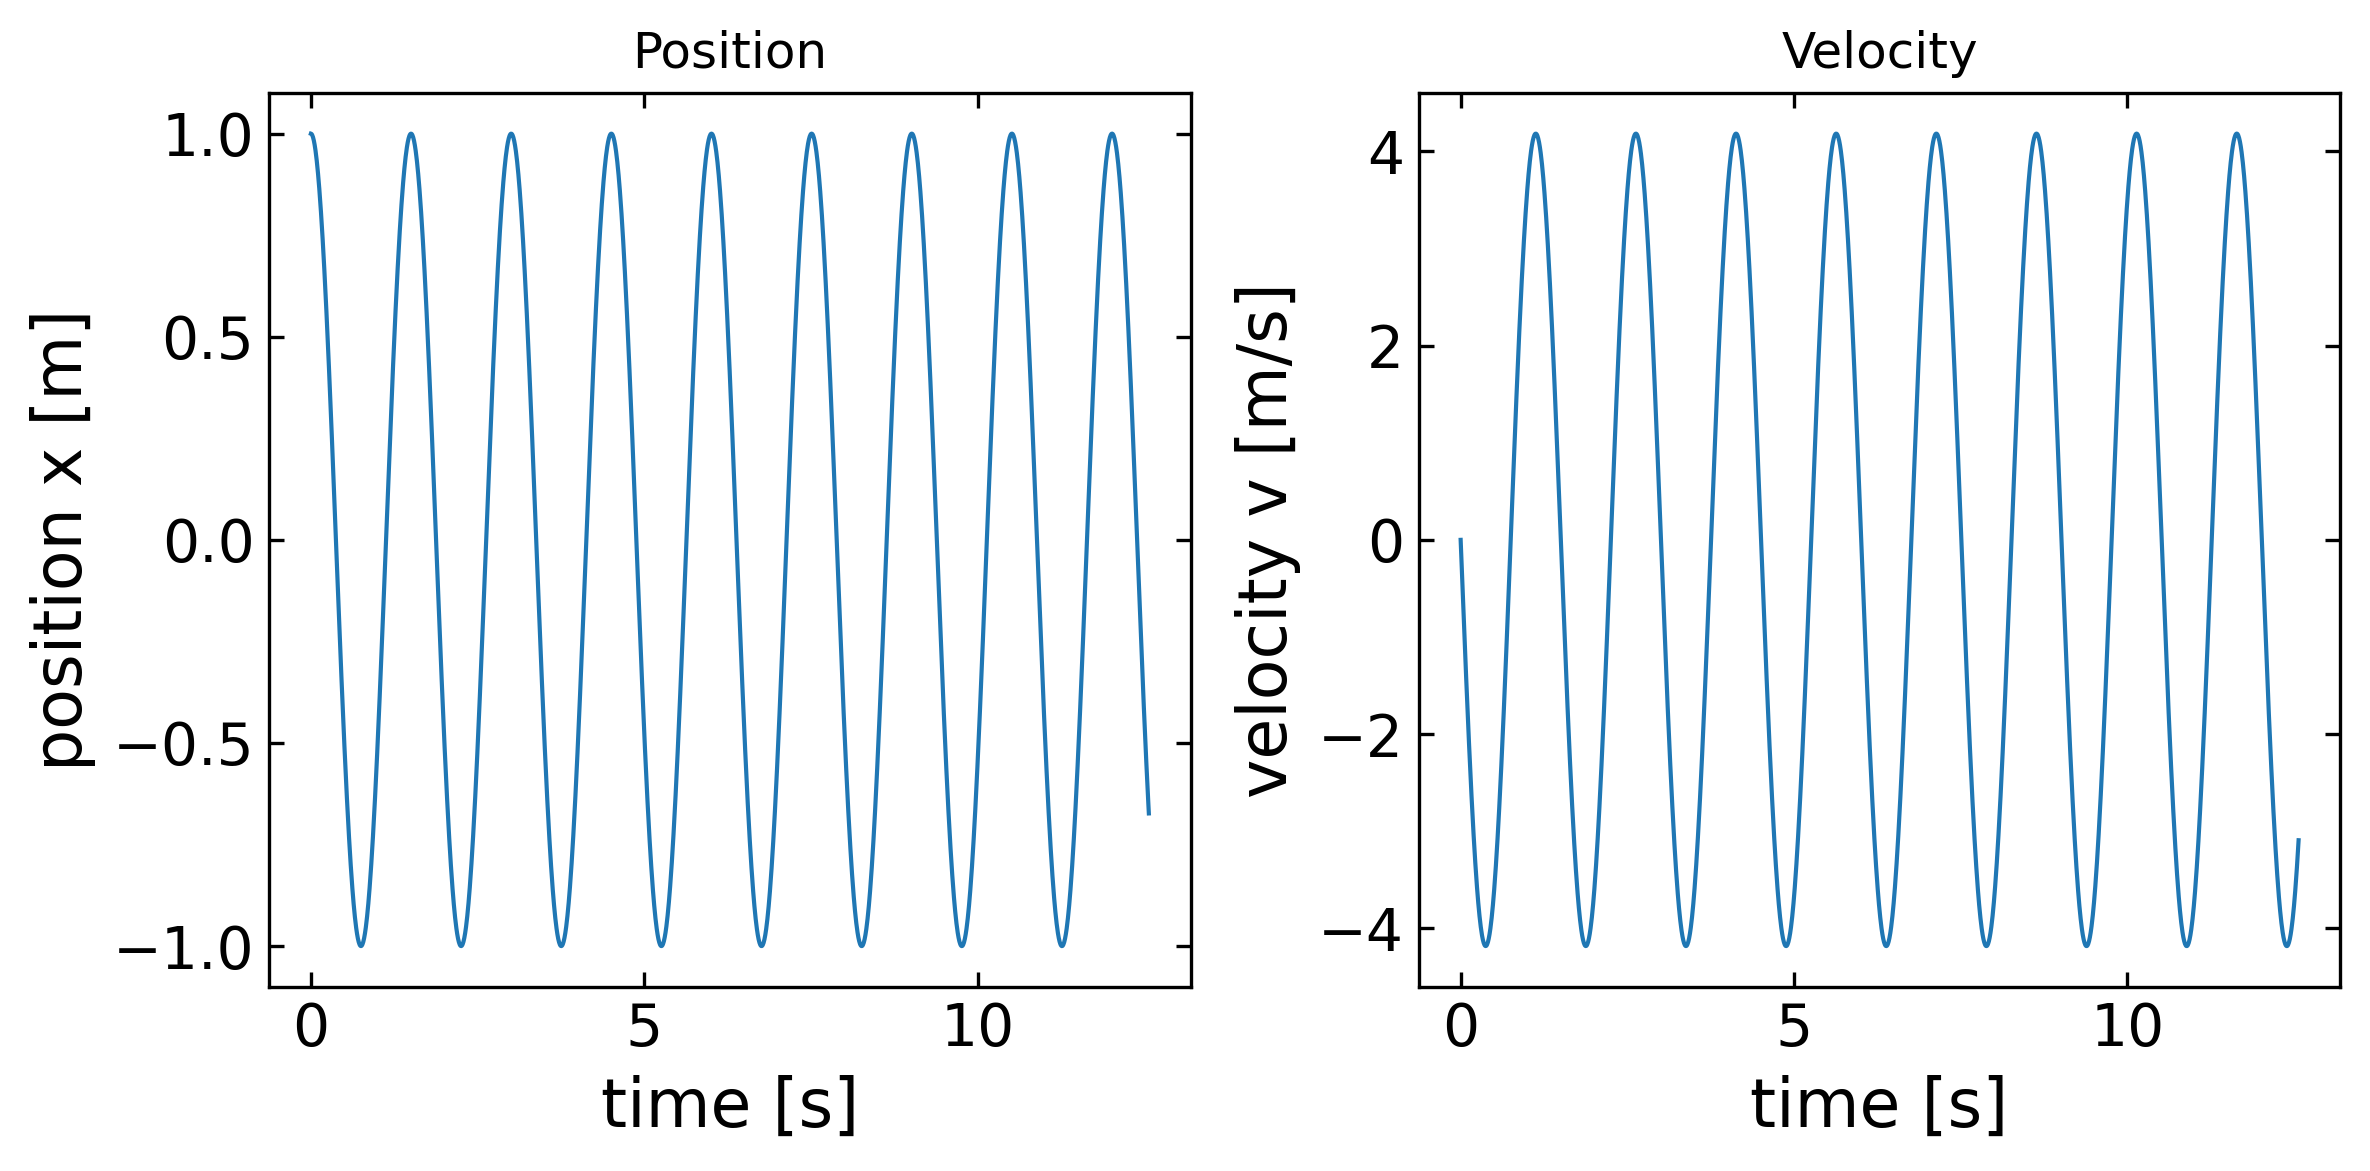

In [11]:
N = 2000  # number of steps
tau = 4*np.pi # time period
xo = 1.0 # initial position
vo = 0.0 # initial velocity


k = 3.5 
m = 0.2
gravity = 9.8

dt = tau/float(N-1)
time = np.linspace(0, tau, N)

y = np.zeros ([N,2])
y[0,0] = xo 
y[0,1] = vo

##  defining the problem
def free_fall(state , time): 
    g0 = state[1]
    g1 = -gravity
    return(np.array([g0, g1]))

def SHO(state, time):
    g0 = state[1]
    g1 = -k/m * state[0]
    return(np.array([g0, g1]))

##  solving the problem with euler
def euler(y, t, dt, derivs): 
    y_next = y + derivs(y,t)* dt 
    return(y_next)


##  solving the problem with runge kutta
def runge_kutta2(y, time, dt, derivs):
    k0 = dt * derivs(y, time)
    k1 = dt * derivs(y + k0, time + dt) 
    y_next = y + 0.5 * (k0 + k1)
    return(y_next)

##  loop through the timesteps
for j in range(N-1):
    y[j+1] = runge_kutta2(y[j], time[j], dt, SHO)                       


##  do the plotting
xdata = [y[j,0] for j in range(N)] 
vdata = [y[j,1] for j in range(N)]


fig=plt.figure(1, figsize = (8,4) )
plt.subplot(1, 2, 1)
plt.plot(time, xdata)
plt.title("Position") 
plt.xlabel('time [s]', fontsize=16)
plt.ylabel('position x [m]',fontsize=16)
plt.tick_params(labelsize=14)

plt.subplot(1, 2, 2)
plt.plot(time, vdata)
plt.title("Velocity") 
plt.xlabel('time [s]', fontsize=16)
plt.ylabel('velocity v [m/s]',fontsize=16)
plt.tick_params(labelsize=14)

plt.tight_layout() 
plt.show()    

## Solving the Harmonic Oscillator in SciPy

As our Euler integration scheme is not vrey accurate, we may use predefined modules with their methods to do the integration. The module `SciPy` inludes the method `scipy.integrate.odeint()` which is an integrator as our `Euler method`. To use this function just include 

~~~
from scipy.integrate import odeint
~~~

and you may call the function just by `answer=odeint(derivs,y,time)`. 

Here the `derivs` function is the same as we have supplied to our solvers, so just `SHO`, `y` contains a 1-dimensional vector with the initial conditions and `time` the timesteps at which you would like to calculate the solution. 

The *odeint* function is much more sophisticated as our solver, as it contains error correction and other things. As you know now the background behind solving differential equations a bit, you may be allowed to use this function ;-). The results of the function are stored in the variable `answer`. Check out the variable and find out what is stored where! Play around with the code below!

### Setup

In [12]:
from scipy.integrate import odeint

In [13]:
N = 1000  # number of steps
xo = 1.0 # initial position
vo = 0.0 # initial velocity
tau = 4*np.pi # time period

k = 3.5 
m = 0.2
gravity = 9.8

time = np.linspace(0, tau, N)

y = np.zeros(2)
y[0] = xo  
y[1] = vo



### Definition

In [14]:
##  defining the problem
def SHO(state, time):
    g0 = state[1]
    g1 = -k/m * state [0]
    return(np.array([g0, g1]))

### Solution

In [15]:
answer = odeint( free_fall, y , time ) 

### Plotting

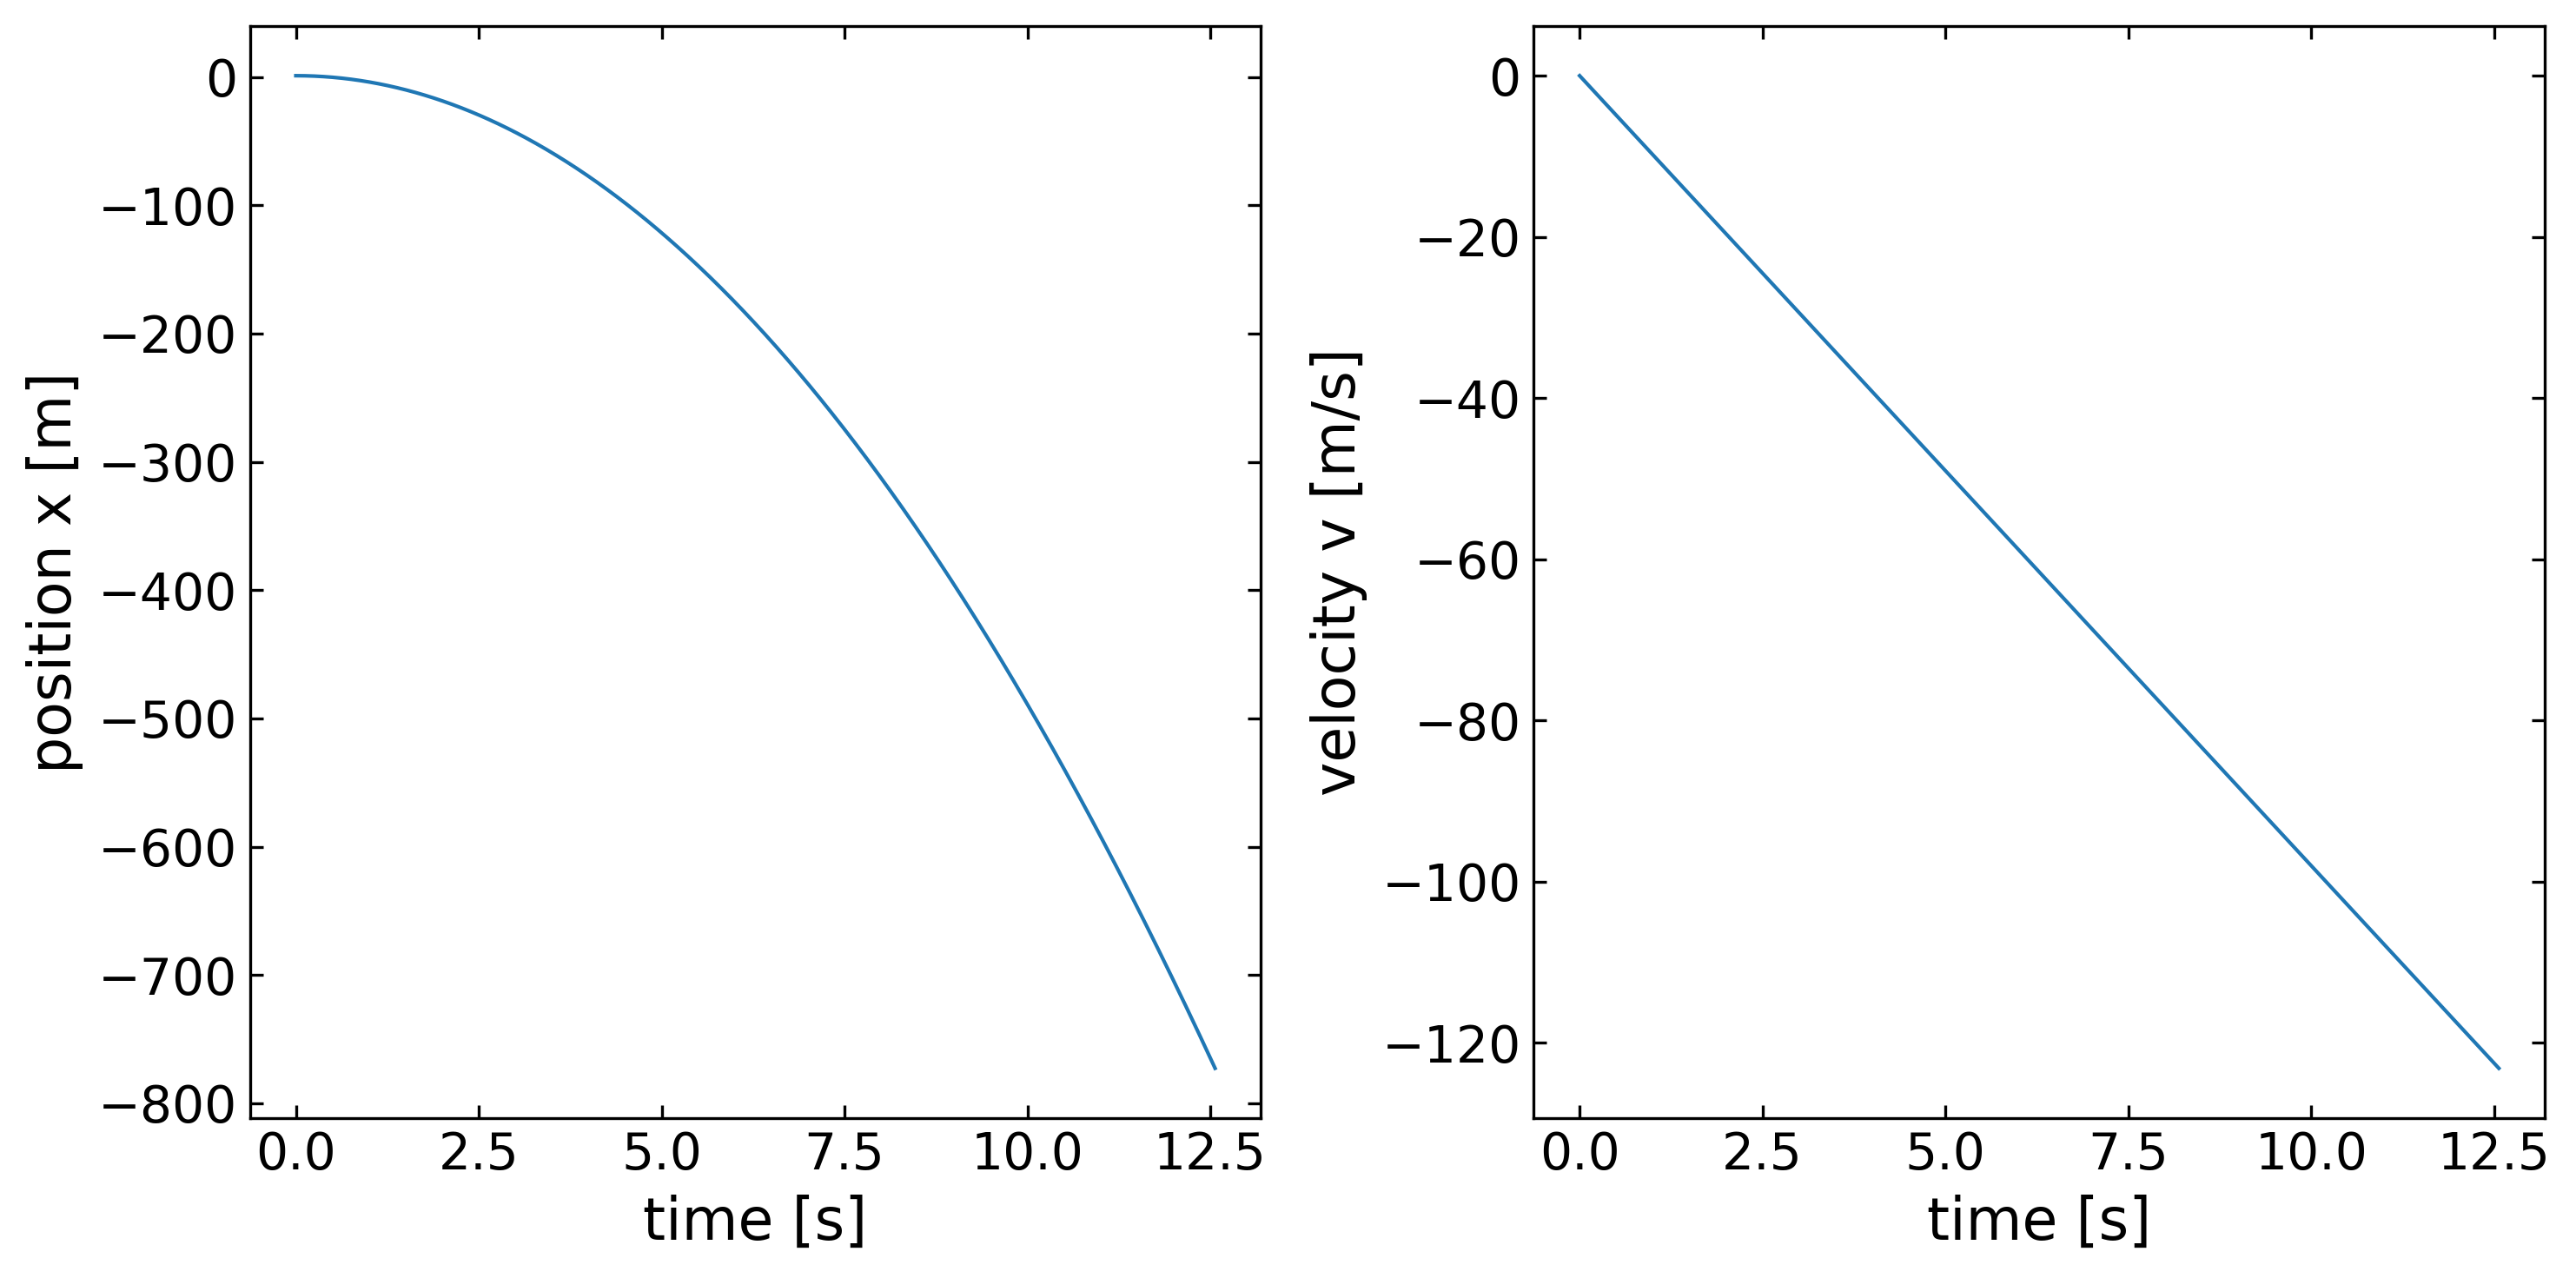

In [16]:
fig=plt.figure(1, figsize = (10,5) )
plt.subplot(1, 2, 1)
plt.plot(time, answer[:,0])
plt.ylabel("position , velocity") 
plt.xlabel('time [s]', fontsize=16)
plt.ylabel('position x [m]',fontsize=16)
plt.tick_params(labelsize=14)

plt.subplot(1, 2, 2)
plt.plot(time, answer[:,1])
plt.xlabel('time [s]', fontsize=16)
plt.ylabel('velocity v [m/s]',fontsize=16)
plt.tick_params(labelsize=14)

plt.tight_layout() 
plt.show()    

## Damped Driven Pendulum in SciPy



Write a `derivs` function for a damped driven pendulum:

\begin{equation}
\ddot{\theta}=-\frac{g}{L}\sin(\theta)-b \dot{\theta}+\beta\cos(\omega t)
\end{equation}

Use this *derivs* function with the *SciPy* solver and plot the result for different parameters. Vary the damping parameter $b$. Observe the contributions of the homogeneous and the particular solution. Plot the amplitude of the stationary solution as a function of frequency!

### Setup

In [17]:
N = 10000  # number of steps
theta_o = 1.0 # initial position
vo = -0.0 # initial velocity
tau = 100.0 # time period

length=10.0
b=0.2
beta=np.pi/2
gravity = 9.8
omega=np.sqrt(gravity/length)


time = np.linspace(0, tau, N)

y = np.zeros (2)
y[0] = theta_o 
y[1] = vo

### Definition

In [18]:
def pendulum_def(state , time):
    g0 = state[1]
    g1 = -gravity/length * np.sin(state[0]) - b*state[1] + beta*np.cos(omega * time)
    return(np.array([g0, g1]) )

### Solution

In [19]:
answer = odeint( pendulum_def, y , time )

### Plotting

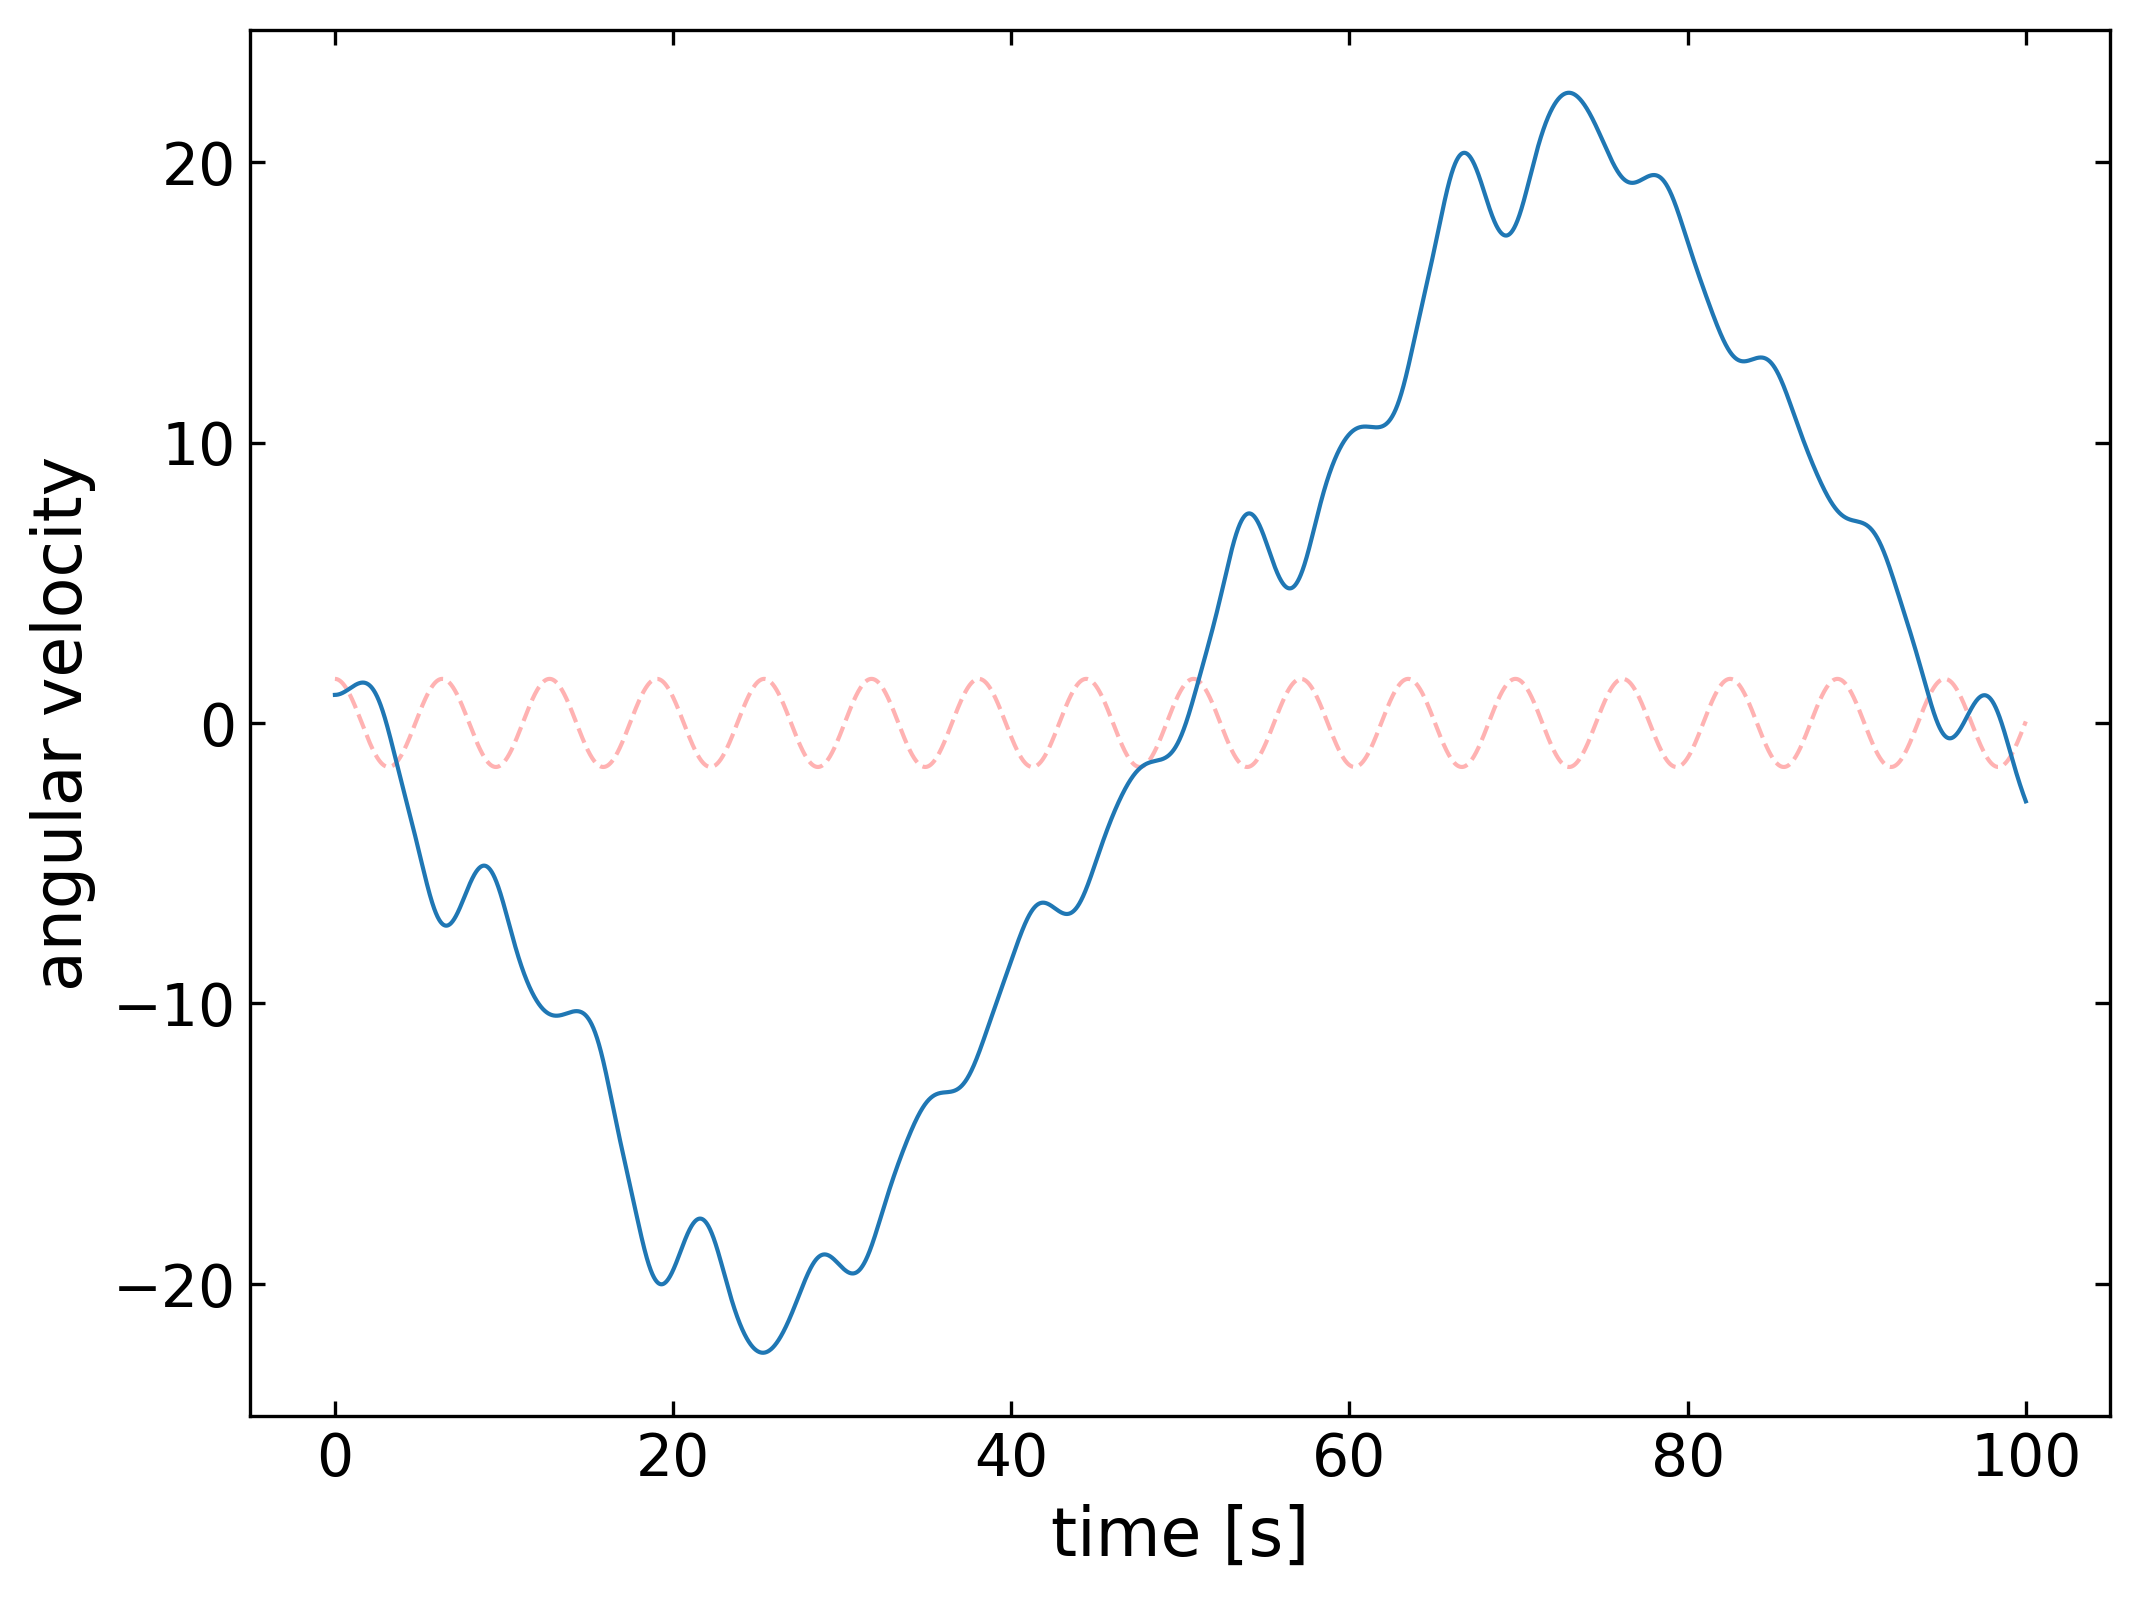

In [20]:
fig=plt.figure(1, figsize = (8,6) )
plt.plot(time,beta*np.cos(omega * time),'r--',alpha=0.3)
plt.plot(time, answer[:,0])
plt.xlabel('time [s]', fontsize=16)
plt.ylabel('angular velocity',fontsize=16)
plt.tick_params(labelsize=14)
plt.show()